In [142]:
import math
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from beautifultable import BeautifulTable

import arff
from weka.core.converters import Loader
from weka.classifiers import Classifier, Evaluation, PredictionOutput
from weka.core.classes import Random
import weka.plot.classifiers as plcls 
from imblearn.over_sampling import SMOTE
import weka.core.jvm as jvm
import javabridge
import weka.plot.classifiers as pl2  

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
jvm.start(packages=True)

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/javabridge/jars/rhino-1.7R4.jar', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/javabridge/jars/runnablequeue.jar', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/javabridge/jars/cpython.jar', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/weka/lib/python-weka-wrapper.jar', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/weka/lib/weka.jar', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/weka/lib/python-weka-wrapper.jar', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/weka/lib/weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support enabled


In [3]:
def printConfusionMatrix(trueNegative, falsePositive, falseNegative, truePositive):
    tableData = []
    row1 = []
    row1.append('')
    row1.append('Predicted Pos')
    row1.append('Predicted Neg')
    tableData.append(row1)
    
    row2 = []
    row2.append('Actual Pos')
    row2.append(truePositive)
    row2.append(falseNegative)
    tableData.append(row2)
    
    row3 = []
    row3.append('Actual Neg')
    row3.append(falsePositive)
    row3.append(trueNegative)
    tableData.append(row3)
    
    printDatainTable([], tableData)

In [4]:
def printDatainTable(tableHeaders, tableData):
    table = BeautifulTable(max_width=100)
    table.set_style(BeautifulTable.STYLE_SEPARATED)
    if len(tableHeaders)!=0:
        table.column_headers = tableHeaders
    for i in range(0, len(tableData)):
        table.append_row(tableData[i])
    print(table)

In [3]:
apsTrainingURL = 'https://raw.githubusercontent.com/SurbhiJainUSC/Tree-based-Classifier/master/APS%20Failure%20Data/Training%20Data/'
apsTrainingFileName = 'aps_failure_training_set-'
apsTestingURL = 'https://raw.githubusercontent.com/SurbhiJainUSC/Tree-based-Classifier/master/APS%20Failure%20Data/aps_failure_test_set.csv'


# Read APS Failure Data.

In [24]:
apsTrainData = pd.DataFrame()
for i in range(1, 6):
    apsTrainingFileURL = apsTrainingURL + apsTrainingFileName + str(i) + '.csv'
    apsData = pd.read_csv(apsTrainingFileURL)
    apsTrainData = pd.concat([apsTrainData, apsData])
print('------------------------------------------------------------------------')
print('Training instances:', apsTrainData.shape[0])
print('------------------------------------------------------------------------')
print('First 5 training observations:')
print('------------------------------------------------------------------------')
print(apsTrainData.head())

------------------------------------------------------------------------
Training instances: 60000
------------------------------------------------------------------------
First 5 training observations:
------------------------------------------------------------------------
  class  aa_000 ab_000      ac_000 ad_000 ae_000 af_000 ag_000 ag_001 ag_002  \
0   neg   76698     na  2130706438    280      0      0      0      0      0   
1   neg   33058     na           0     na      0      0      0      0      0   
2   neg   41040     na         228    100      0      0      0      0      0   
3   neg      12      0          70     66      0     10      0      0      0   
4   neg   60874     na        1368    458      0      0      0      0      0   

   ...   ee_002  ee_003  ee_004  ee_005  ee_006  ee_007  ee_008 ee_009 ef_000  \
0  ...  1240520  493384  721044  469792  339156  157956   73224      0      0   
1  ...   421400  178064  293306  245416  133654   81140   97576   1500      0   


In [25]:
apsTestData = pd.read_csv(apsTestingURL, skiprows=20)
print('------------------------------------------------------------------------')
print('Testing instances:', apsTestData.shape[0])
print('------------------------------------------------------------------------')
print('First 5 testing observations:')
print('------------------------------------------------------------------------')
print(apsTestData.head())

------------------------------------------------------------------------
Testing instances: 16000
------------------------------------------------------------------------
First 5 testing observations:
------------------------------------------------------------------------
  class  aa_000 ab_000 ac_000 ad_000 ae_000 af_000 ag_000 ag_001 ag_002  ...  \
0   neg      60      0     20     12      0      0      0      0      0  ...   
1   neg      82      0     68     40      0      0      0      0      0  ...   
2   neg   66002      2    212    112      0      0      0      0      0  ...   
3   neg   59816     na   1010    936      0      0      0      0      0  ...   
4   neg    1814     na    156    140      0      0      0      0      0  ...   

   ee_002  ee_003  ee_004  ee_005   ee_006  ee_007  ee_008 ee_009 ef_000  \
0    1098     138     412     654       78      88       0      0      0   
1    1068     276    1620     116       86     462       0      0      0   
2  495076  380368

In [26]:
apsData = pd.concat([apsTrainData, apsTestData])
apsDataY = pd.DataFrame(apsData['class'])
apsDataX = pd.DataFrame(apsData.drop(columns=['class']))
apsFeatures = apsDataX.columns

apsTrainDataY = pd.DataFrame(apsTrainData['class'])
apsTrainDataX = pd.DataFrame(apsTrainData[apsFeatures])

apsTestDataY = pd.DataFrame(apsTestData['class'])
apsTestDataX = pd.DataFrame(apsTestData[apsFeatures])

# Techniques to handle missing values.
1. Substitute missing values with a constant (distinct from all other values) that has a meaning in that domain. <br/>
2. Substitute missing values with the value of the randomly selected observation.<br/>
3. Use statistics such as Mean, Median, Mode to fill out missing values. <br/>
4. Use predictive models where missing values are treated as output of the predictive model and are predicted based on other data points that do not have missing values.<br/>
4. Use iterative methods based on Expectation Maximization to handle missing values.

I will use mean of the feature to fill out any missing values for that feature in the observations.

# Handle missing values.

In [27]:
# Replace na with NaN
apsDataX = apsDataX.replace({'na':None}) 
apsDataX = apsDataX.astype('float64')
apsTrainDataX = apsTrainDataX.replace({'na':None}) 
apsTrainDataX = apsTrainDataX.astype('float64')
apsTestDataX = apsTestDataX.replace({'na':None}) 
apsTestDataX = apsTestDataX.astype('float64')

# Find mean for each feature
apsMeansList = apsDataX.mean()
for i in range(0, len(apsMeansList)):
    apsMeansList[i] = round(apsMeansList[i], 2)

# Fill NaN with mean of that column
apsDataX = apsDataX.fillna(apsMeansList)
apsTrainDataX = apsTrainDataX.fillna(apsMeansList)
apsTestDataX = apsTestDataX.fillna(apsMeansList)

actualDataY = np.array(apsDataY).flatten()
actualTrainDataY = np.array(apsTrainDataY).flatten()
actualTestDataY = np.array(apsTestDataY).flatten()

for i in range(0, len(actualDataY)):
    if actualDataY[i]=='neg':
        actualDataY[i] = 0
    else:
        actualDataY[i] = 1

for i in range(0, len(actualTrainDataY)):
    if actualTrainDataY[i]=='neg':
        actualTrainDataY[i] = 0
    else:
        actualTrainDataY[i] = 1

for i in range(0, len(actualTestDataY)):
    if actualTestDataY[i]=='neg':
        actualTestDataY[i] = 0
    else:
        actualTestDataY[i] = 1

In [28]:
print('------------------------------------------------------------------------')
print('First 5 train observations with no missing values:')
print('------------------------------------------------------------------------')
print(apsTrainDataX.head())

------------------------------------------------------------------------
First 5 train observations with no missing values:
------------------------------------------------------------------------
    aa_000  ab_000        ac_000     ad_000  ae_000  af_000  ag_000  ag_001  \
0  76698.0    0.73  2.130706e+09     280.00     0.0     0.0     0.0     0.0   
1  33058.0    0.73  0.000000e+00  150629.96     0.0     0.0     0.0     0.0   
2  41040.0    0.73  2.280000e+02     100.00     0.0     0.0     0.0     0.0   
3     12.0    0.00  7.000000e+01      66.00     0.0    10.0     0.0     0.0   
4  60874.0    0.73  1.368000e+03     458.00     0.0     0.0     0.0     0.0   

   ag_002  ag_003  ...     ee_002    ee_003    ee_004    ee_005    ee_006  \
0     0.0     0.0  ...  1240520.0  493384.0  721044.0  469792.0  339156.0   
1     0.0     0.0  ...   421400.0  178064.0  293306.0  245416.0  133654.0   
2     0.0     0.0  ...   277378.0  159812.0  423992.0  409564.0  320746.0   
3     0.0   318.0  .

In [29]:
print('------------------------------------------------------------------------')
print('First 5 test observations with no missing values:')
print('------------------------------------------------------------------------')
print(apsTestDataX.head())

------------------------------------------------------------------------
First 5 test observations with no missing values:
------------------------------------------------------------------------
    aa_000  ab_000  ac_000  ad_000  ae_000  af_000  ag_000  ag_001  ag_002  \
0     60.0    0.00    20.0    12.0     0.0     0.0     0.0     0.0     0.0   
1     82.0    0.00    68.0    40.0     0.0     0.0     0.0     0.0     0.0   
2  66002.0    2.00   212.0   112.0     0.0     0.0     0.0     0.0     0.0   
3  59816.0    0.73  1010.0   936.0     0.0     0.0     0.0     0.0     0.0   
4   1814.0    0.73   156.0   140.0     0.0     0.0     0.0     0.0     0.0   

     ag_003  ...    ee_002    ee_003    ee_004    ee_005     ee_006    ee_007  \
0    2682.0  ...    1098.0     138.0     412.0     654.0       78.0      88.0   
1       0.0  ...    1068.0     276.0    1620.0     116.0       86.0     462.0   
2  199486.0  ...  495076.0  380368.0  440134.0  269556.0  1315022.0  153680.0   
3       0.0

# Coefficient of Variation (CV) for each feature.

In [30]:
tableData = []
apsCVList = {}
for featureName in apsFeatures:
    data = apsDataX[featureName]
    mean = data.mean()
    std = data.std()
    cv = round(std/mean, 3)
    apsCVList[featureName] = cv
    row = []
    row.append(featureName)
    row.append(cv)
    tableData.append(row)
print('----------------------------------------------------')
print('COEFFICIENT OF VARIATION:')
print('----------------------------------------------------')
tableHeaders = ['Feature Name', 'Coefficient of Variation']
printDatainTable(tableHeaders, tableData)

----------------------------------------------------
COEFFICIENT OF VARIATION:
----------------------------------------------------
+==============+==========================+
| Feature Name | Coefficient of Variation |
+==============+==========================+
|    aa_000    |          4.329           |
+--------------+--------------------------+
|    ab_000    |          2.168           |
+--------------+--------------------------+
|    ac_000    |          2.168           |
+--------------+--------------------------+
|    ad_000    |         206.722          |
+--------------+--------------------------+
|    ae_000    |          22.293          |
+--------------+--------------------------+
|    af_000    |          18.209          |
+--------------+--------------------------+
|    ag_000    |          91.461          |
+--------------+--------------------------+
|    ag_001    |          42.084          |
+--------------+--------------------------+
|    ag_002    |          17.626

# Correlation matrix for each feature.

In [31]:
print('------------------------------------------------------------------------')
print('CORRELATION MATRIX')
print('------------------------------------------------------------------------')
apsCorrelation = apsDataX.corr()
apsCorrelation.style.background_gradient(cmap='coolwarm')

------------------------------------------------------------------------
CORRELATION MATRIX
------------------------------------------------------------------------


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


# Scatter plot of sqrt(170) features with highest CV.

------------------------------------------------------------------------
SCATTER PLOT OF 13 FEATURES
------------------------------------------------------------------------


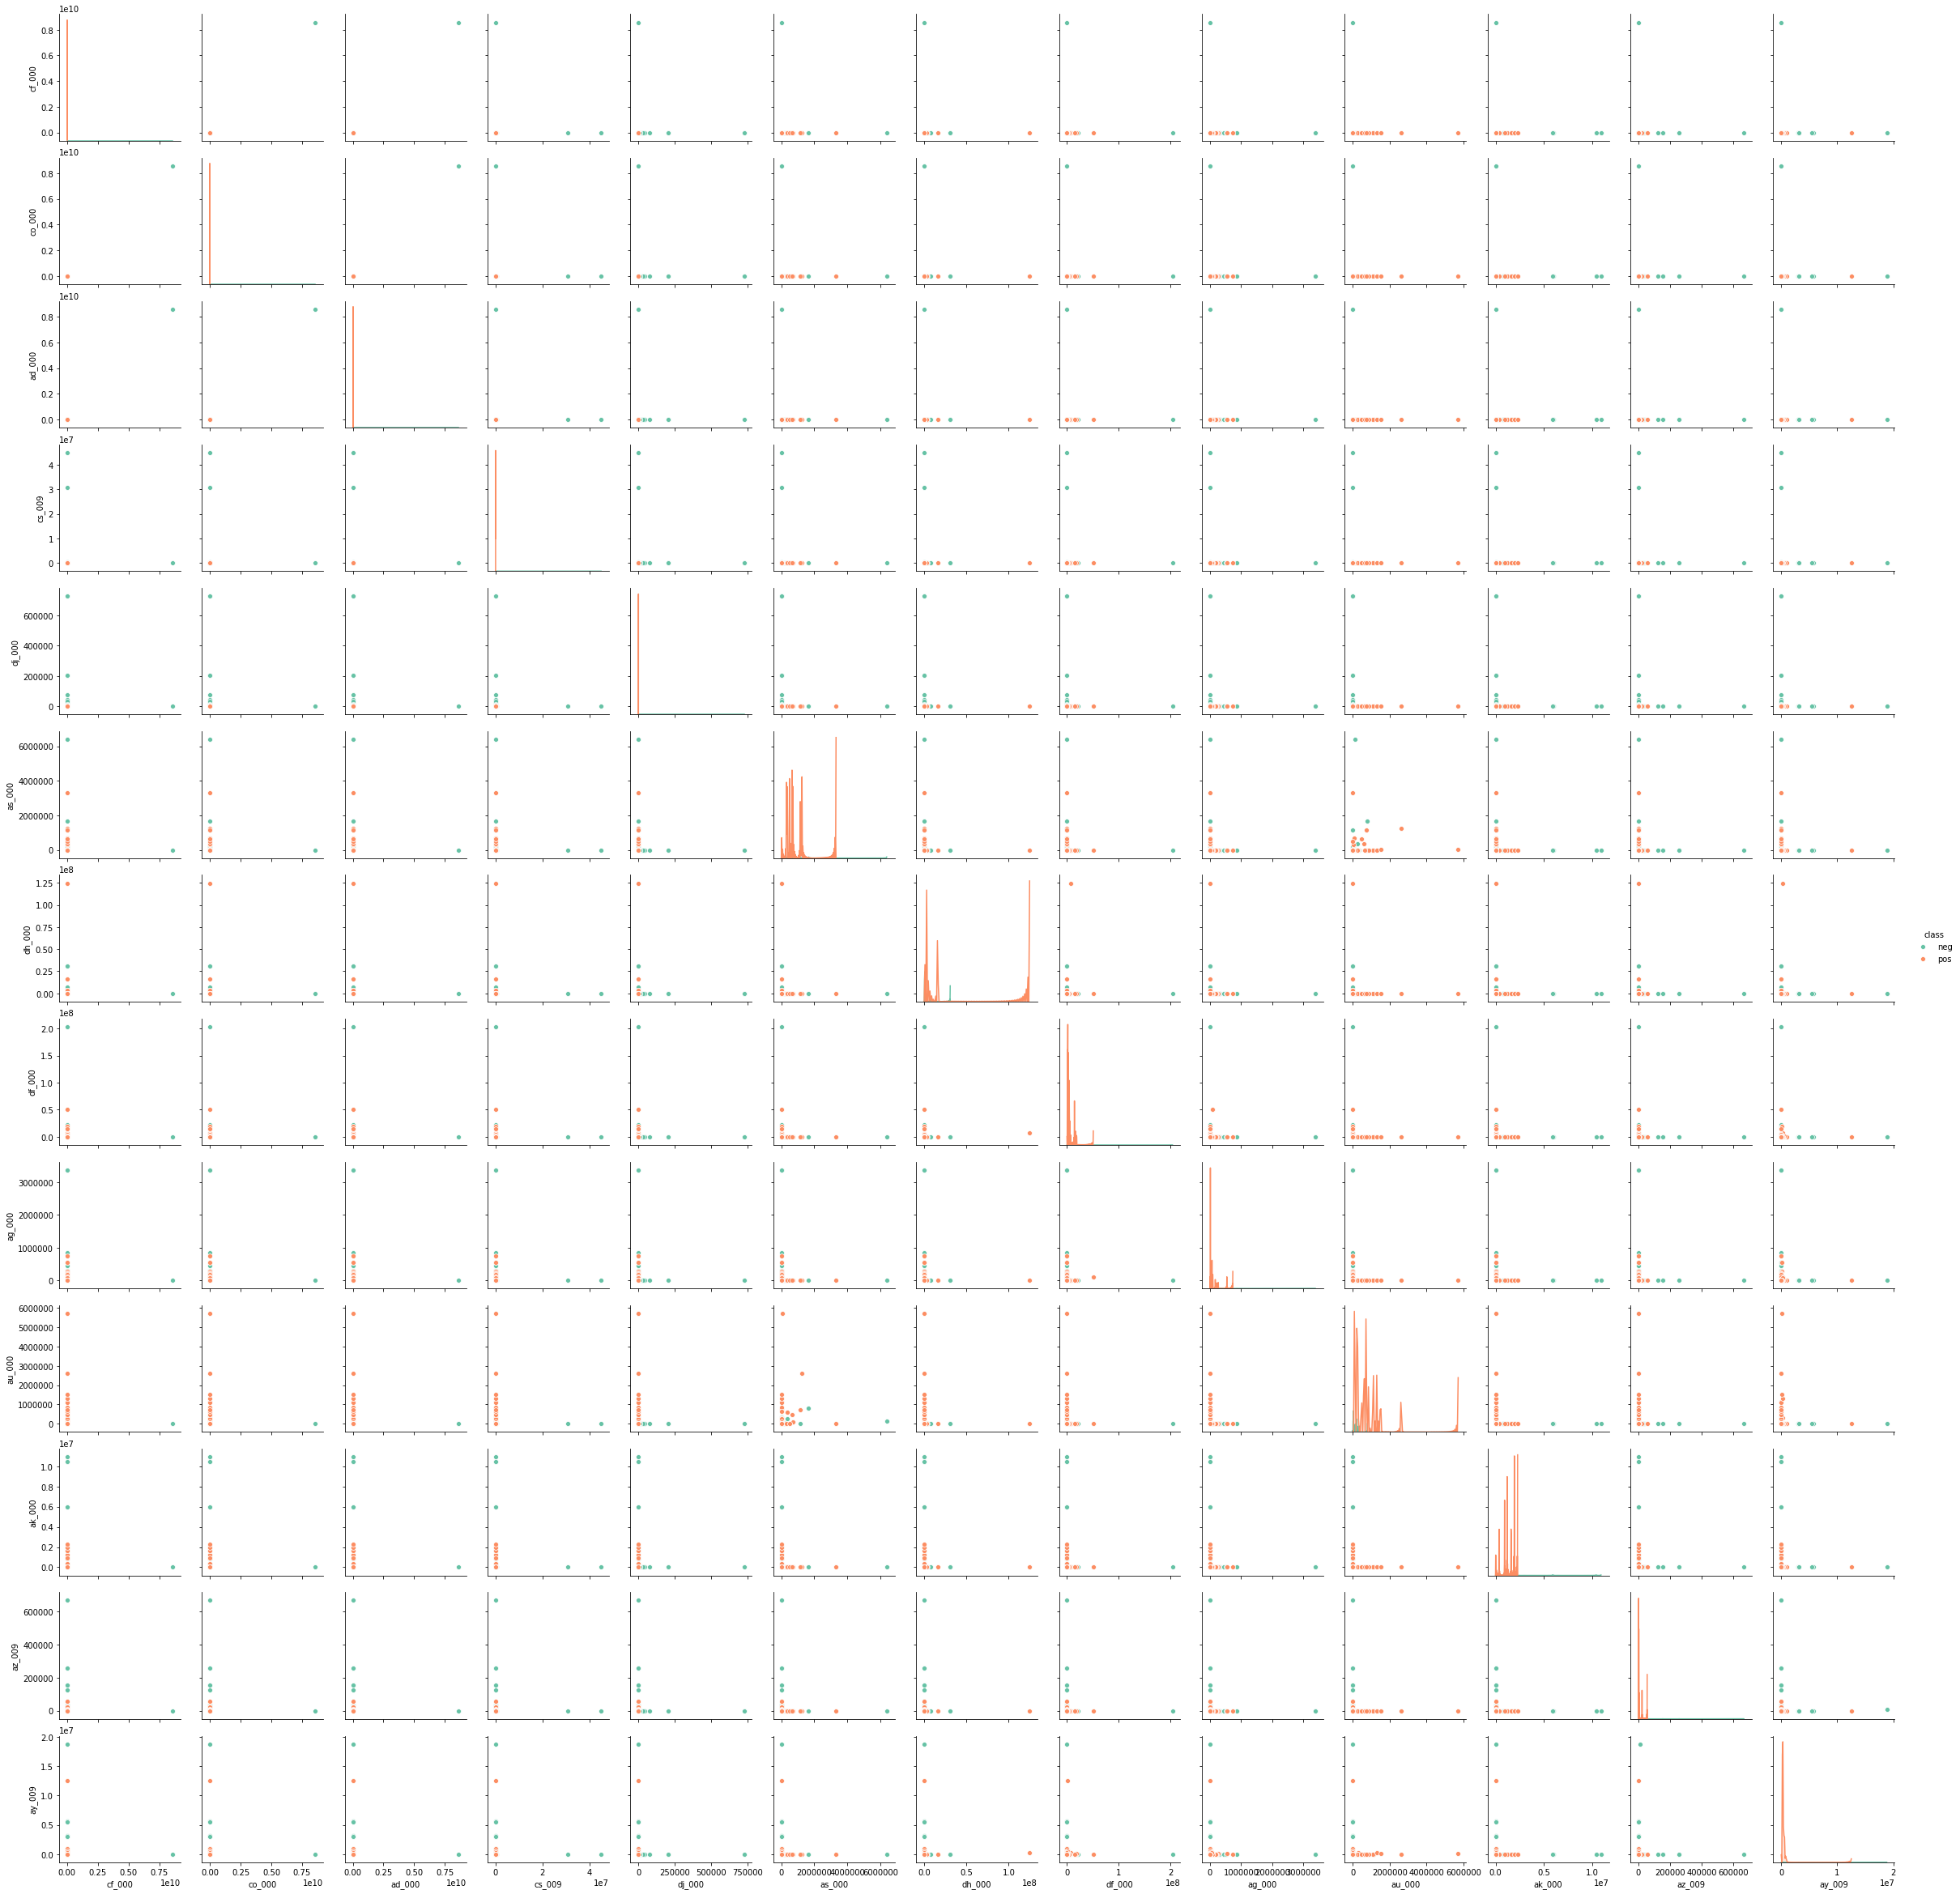

In [143]:
print('------------------------------------------------------------------------')
print('SCATTER PLOT OF 13 FEATURES')
print('------------------------------------------------------------------------')
apsTopN = round(math.sqrt(170))
sortedApsCVs = sorted(apsCVList.items(), key=operator.itemgetter(1), reverse=True)
apsPlotData = pd.DataFrame()
for i in range(0, apsTopN):
    featureName = sortedApsCVs[i][0]
    featureData = apsDataX[featureName][:]
    apsPlotData = pd.concat([apsPlotData, featureData], axis=1)
apsPlotData = pd.concat([apsPlotData, apsDataY], axis=1)

sb.pairplot(apsPlotData, hue='class')

## Findings:
This scatterplot depicts that classes are linearly separable for some of the feature pairs.

# Box plot of sqrt(170) features with highest CV.

---------------------------------
BOX PLOT OF 13 FEATURES
---------------------------------


cf_000         AxesSubplot(0.1,0.736957;0.173913x0.163043)
co_000    AxesSubplot(0.308696,0.736957;0.173913x0.163043)
ad_000    AxesSubplot(0.517391,0.736957;0.173913x0.163043)
cs_009    AxesSubplot(0.726087,0.736957;0.173913x0.163043)
dj_000         AxesSubplot(0.1,0.541304;0.173913x0.163043)
as_000    AxesSubplot(0.308696,0.541304;0.173913x0.163043)
dh_000    AxesSubplot(0.517391,0.541304;0.173913x0.163043)
df_000    AxesSubplot(0.726087,0.541304;0.173913x0.163043)
ag_000         AxesSubplot(0.1,0.345652;0.173913x0.163043)
au_000    AxesSubplot(0.308696,0.345652;0.173913x0.163043)
ak_000    AxesSubplot(0.517391,0.345652;0.173913x0.163043)
az_009    AxesSubplot(0.726087,0.345652;0.173913x0.163043)
ay_009             AxesSubplot(0.1,0.15;0.173913x0.163043)
dtype: object

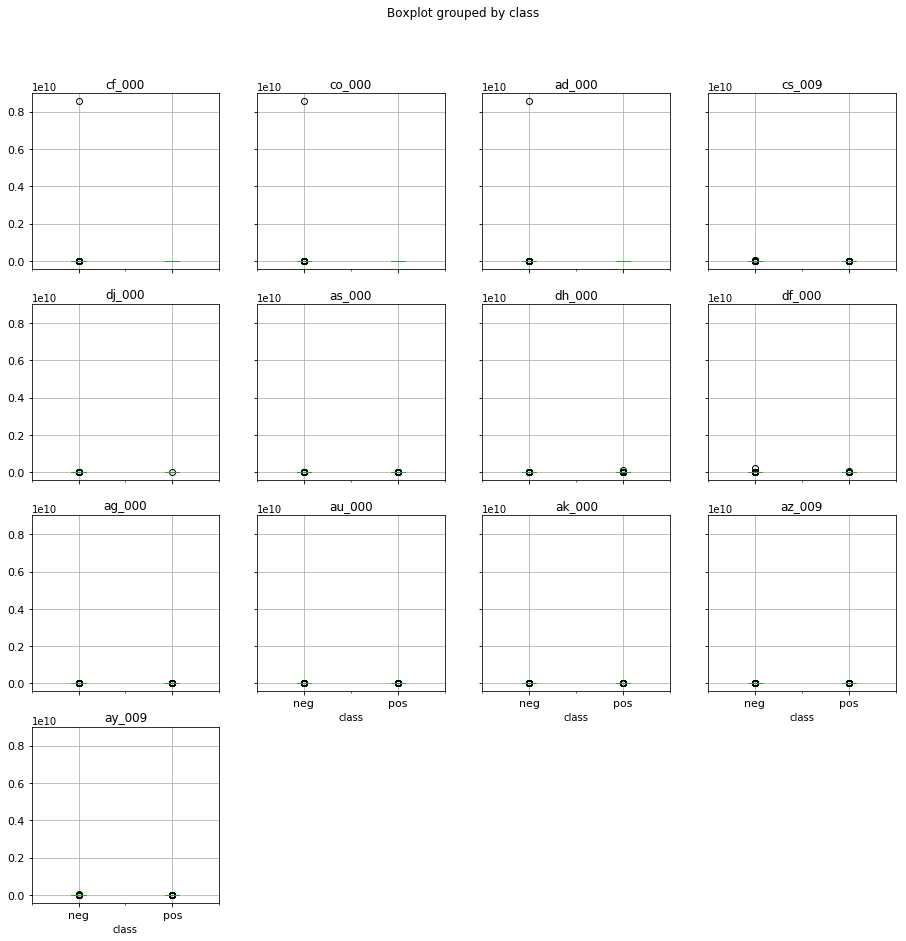

In [33]:
print('---------------------------------')
print('BOX PLOT OF 13 FEATURES')
print('---------------------------------')
columnNames = apsPlotData.columns
columns = []
for i in range(0, len(columnNames)-1):
    columns.append(columnNames[i])

apsPlotData.boxplot(column=columns, by='class', fontsize=11, figsize=(15, 15), return_type='axes')

# Is the data imbalanced?

In [148]:
negTrain = 0
posTrain = 0
for i in range(0, len(actualTrainDataY)):
    if actualTrainDataY[i]==0:
        negTrain += 1
    else:
        posTrain += 1
print('------------------------------------')
print('TRAINING DATA:')
print('Positive class count:', posTrain)
print('Negative class count:', negTrain)

negTest = 0
posTest = 0
for i in range(0, len(actualTestDataY)):
    if actualTestDataY[i]==0:
        negTest += 1
    else:
        posTest += 1
print('------------------------------------')
print('TESTING DATA:')
print('Positive class count:', posTest)
print('Negative class count:', negTest)
print('------------------------------------')

------------------------------------
TRAINING DATA:
Positive class count: 1000
Negative class count: 59000
------------------------------------
TESTING DATA:
Positive class count: 375
Negative class count: 15625
------------------------------------


## Findings:
Yes, the data set is highly imbalanced because there are 74625 observations that belong to 'neg' class, and only 1375 observations belong to class 'pos'.

# Random Forest Classifier.

In [35]:
actualTrainDataY = list(actualTrainDataY)
actualTestDataY = list(actualTestDataY)

randomForestModel = RandomForestClassifier(n_estimators=100,oob_score = True)
randomForestModel = randomForestModel.fit(apsTrainDataX, actualTrainDataY)

rfTestPredictedY = randomForestModel.predict(apsTestDataX)
rfTrainPredictedY = randomForestModel.predict(apsTrainDataX)

rfTrainAccuracy = accuracy_score(actualTrainDataY, rfTrainPredictedY)
rfTrainAccuracy = round(rfTrainAccuracy, 3)
print('------------------------------------------------------------------------')
print("TRAIN ACCURACY OF RANDOM FOREST: ", rfTrainAccuracy)
print('------------------------------------------------------------------------')

rfTrainError = 1-rfTrainAccuracy
rfTrainError = round(rfTrainError, 3)
print("TRAIN ERROR OF RANDOM FOREST: ", rfTrainError)
print('------------------------------------------------------------------------')

rfTestAccuracy = accuracy_score(actualTestDataY, rfTestPredictedY)
rfTestAccuracy = round(rfTestAccuracy, 3)
print("TEST ACCURACY OF RANDOM FOREST: ", rfTestAccuracy)
print('------------------------------------------------------------------------')

rfTestError = 1-rfTestAccuracy
rfTestError = round(rfTestError, 3)
print("TEST ERROR OF RANDOM FOREST: ", rfTestError)
print('------------------------------------------------------------------------')

oobError = 1-randomForestModel.oob_score_
oobError = round(oobError, 3)
print('OUT OF BAG ERROR:', oobError)
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
TRAIN ACCURACY OF RANDOM FOREST:  1.0
------------------------------------------------------------------------
TRAIN ERROR OF RANDOM FOREST:  0.0
------------------------------------------------------------------------
TEST ACCURACY OF RANDOM FOREST:  0.992
------------------------------------------------------------------------
TEST ERROR OF RANDOM FOREST:  0.008
------------------------------------------------------------------------
OUT OF BAG ERROR: 0.006
------------------------------------------------------------------------


It is clear that the Out of Bag Error is a valid estimate of test error.

In [36]:
print('----------------------------------------------')
print('CONFUSION MATRIX FOR TRAIN DATA')
print('----------------------------------------------')
rfTrainConfusionMatrix = confusion_matrix(actualTrainDataY, rfTrainPredictedY)
RFTrainTN, RFTrainFP, RFTrainFN, RFTrainTP = rfTrainConfusionMatrix.ravel()
printConfusionMatrix(RFTrainTN, RFTrainFP, RFTrainFN, RFTrainTP)

print('----------------------------------------------')
print('CONFUSION MATRIX FOR TEST DATA')
print('----------------------------------------------')
rfTestConfusionMatrix = confusion_matrix(actualTestDataY, rfTestPredictedY)
RFTestTN, RFTestFP, RFTestFN, RFTestTP = rfTestConfusionMatrix.ravel()
printConfusionMatrix(RFTestTN, RFTestFP, RFTestFN, RFTestTP)

----------------------------------------------
CONFUSION MATRIX FOR TRAIN DATA
----------------------------------------------
+============+===============+===============+
|            | Predicted Pos | Predicted Neg |
+------------+---------------+---------------+
| Actual Pos |     1000      |       0       |
+------------+---------------+---------------+
| Actual Neg |       0       |     59000     |
+------------+---------------+---------------+
----------------------------------------------
CONFUSION MATRIX FOR TEST DATA
----------------------------------------------
+============+===============+===============+
|            | Predicted Pos | Predicted Neg |
+------------+---------------+---------------+
| Actual Pos |      268      |      107      |
+------------+---------------+---------------+
| Actual Neg |      18       |     15607     |
+------------+---------------+---------------+


In [37]:
print('----------------------------------------------')
print("MISCLASSIFICATIONS FOR TRAIN DATA:")
print('----------------------------------------------')
print("TOTAL FALSE POSITIVES:", RFTrainFP)
print("TOTAL FALSE NEGATIVES:", RFTrainFN)
print("TOTAL MISCLASSIFICATIONS:", RFTrainFP+RFTrainFN)
print('----------------------------------------------')
print('----------------------------------------------')
print("MISCLASSIFICATIONS FOR TEST DATA:")
print('----------------------------------------------')
print("TOTAL FALSE POSITIVES:", RFTestFP)
print("TOTAL FALSE NEGATIVES:", RFTestFN)
print("TOTAL MISCLASSIFICATIONS:", RFTestFP+RFTestFN)
print('----------------------------------------------')

----------------------------------------------
MISCLASSIFICATIONS FOR TRAIN DATA:
----------------------------------------------
TOTAL FALSE POSITIVES: 0
TOTAL FALSE NEGATIVES: 0
TOTAL MISCLASSIFICATIONS: 0
----------------------------------------------
----------------------------------------------
MISCLASSIFICATIONS FOR TEST DATA:
----------------------------------------------
TOTAL FALSE POSITIVES: 18
TOTAL FALSE NEGATIVES: 107
TOTAL MISCLASSIFICATIONS: 125
----------------------------------------------


----------------------------------------------
ROC FOR TRAIN DATA:


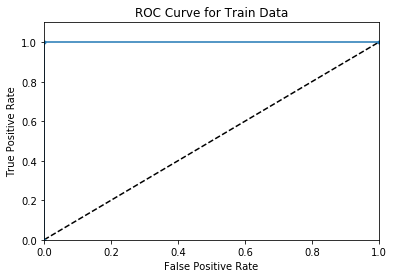

----------------------------------------------
AUC FOR TRAIN DATA: 1.0
----------------------------------------------
----------------------------------------------
ROC FOR TEST DATA:


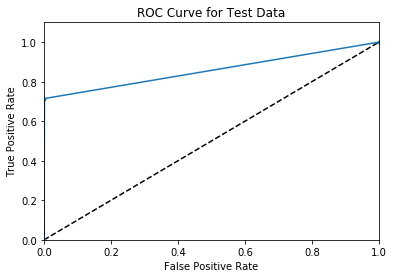

----------------------------------------------
AUC FOR TEST DATA: 0.857
----------------------------------------------


In [150]:
RFTrainFPR, RFTrainTPR, RFTrainThreshold = roc_curve(actualTrainDataY, rfTrainPredictedY)
RFTrainAUC = round(roc_auc_score(actualTrainDataY, rfTrainPredictedY), 3)

print('----------------------------------------------')
print("ROC FOR TRAIN DATA:")
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.plot(RFTrainFPR, RFTrainTPR, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Train Data")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.show()
print('----------------------------------------------')
print("AUC FOR TRAIN DATA:", RFTrainAUC)
print('----------------------------------------------')

RFTestFPR, RFTestTPR, RFTestThreshold = roc_curve(actualTestDataY, rfTestPredictedY)
RFTestAUC = round(roc_auc_score(actualTestDataY, rfTestPredictedY), 3)

print('----------------------------------------------')
print("ROC FOR TEST DATA:")
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.plot(RFTestFPR, RFTestTPR, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Test Data")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.show()
print('----------------------------------------------')
print("AUC FOR TEST DATA:", RFTestAUC)
print('----------------------------------------------')


# Random Forest Classifier for Class Imbalance Data.

In [151]:
balancedRFModel = RandomForestClassifier(n_estimators=100, oob_score = True, class_weight='balanced')
balancedRFModel = balancedRFModel.fit(apsTrainDataX, actualTrainDataY)

balancedRFTestPredY = balancedRFModel.predict(apsTestDataX)
balancedRFTrainPredY = balancedRFModel.predict(apsTrainDataX)

balancedRFTrainAccuracy = accuracy_score(actualTrainDataY, balancedRFTrainPredY)
balancedRFTrainAccuracy = round(balancedRFTrainAccuracy, 3)
print('RESULTS AFTER BALANCING CLASSES:')
print('------------------------------------------------------------------------')
print("TRAIN ACCURACY OF RANDOM FOREST: ", balancedRFTrainAccuracy)
print('------------------------------------------------------------------------')

balancedRFTrainError = 1-balancedRFTrainAccuracy
balancedRFTrainError = round(balancedRFTrainError, 3)
print("TRAIN ERROR OF RANDOM FOREST: ", balancedRFTrainError)
print('------------------------------------------------------------------------')

balancedRFTestAccuracy = accuracy_score(actualTestDataY, balancedRFTestPredY)
balancedRFTestAccuracy = round(balancedRFTestAccuracy, 3)
print("TEST ACCURACY OF RANDOM FOREST: ", balancedRFTestAccuracy)
print('------------------------------------------------------------------------')

balancedRFTestError = 1-balancedRFTestAccuracy
balancedRFTestError = round(balancedRFTestError, 3)
print("TEST ERROR OF RANDOM FOREST: ", balancedRFTestError)
print('------------------------------------------------------------------------')

balancedOOBError = 1-balancedRFModel.oob_score_
balancedOOBError = round(balancedOOBError, 3)
print('OUT OF BAG ERROR:', balancedOOBError)
print('------------------------------------------------------------------------')

RESULTS AFTER BALANCING CLASSES:
------------------------------------------------------------------------
TRAIN ACCURACY OF RANDOM FOREST:  1.0
------------------------------------------------------------------------
TRAIN ERROR OF RANDOM FOREST:  0.0
------------------------------------------------------------------------
TEST ACCURACY OF RANDOM FOREST:  0.989
------------------------------------------------------------------------
TEST ERROR OF RANDOM FOREST:  0.011
------------------------------------------------------------------------
OUT OF BAG ERROR: 0.008
------------------------------------------------------------------------


In [40]:
print('----------------------------------------------')
print('CONFUSION MATRIX FOR TRAIN DATA')
print('----------------------------------------------')
balancedRFTrainConfusionMatrix = confusion_matrix(actualTrainDataY, balancedRFTrainPredY)
BRFTrainTN, BRFTrainFP, BRFTrainFN, BRFTrainTP = balancedRFTrainConfusionMatrix.ravel()
printConfusionMatrix(BRFTrainTN, BRFTrainFP, BRFTrainFN, BRFTrainTP)

print('----------------------------------------------')
print('CONFUSION MATRIX FOR TEST DATA')
print('----------------------------------------------')
balancedRFTestConfusionMatrix = confusion_matrix(actualTestDataY, balancedRFTestPredY)
BRFTestTN, BRFTestFP, BRFTestFN, BRFTestTP = balancedRFTestConfusionMatrix.ravel()
printConfusionMatrix(BRFTestTN, BRFTestFP, BRFTestFN, BRFTestTP)

----------------------------------------------
CONFUSION MATRIX FOR TRAIN DATA
----------------------------------------------
+============+===============+===============+
|            | Predicted Pos | Predicted Neg |
+------------+---------------+---------------+
| Actual Pos |     1000      |       0       |
+------------+---------------+---------------+
| Actual Neg |       0       |     59000     |
+------------+---------------+---------------+
----------------------------------------------
CONFUSION MATRIX FOR TEST DATA
----------------------------------------------
+============+===============+===============+
|            | Predicted Pos | Predicted Neg |
+------------+---------------+---------------+
| Actual Pos |      213      |      162      |
+------------+---------------+---------------+
| Actual Neg |      18       |     15607     |
+------------+---------------+---------------+


In [41]:
print('----------------------------------------------')
print("MISCLASSIFICATIONS FOR TRAIN DATA:")
print('----------------------------------------------')
print("TOTAL FALSE POSITIVES:", BRFTrainFP)
print("TOTAL FALSE NEGATIVES:", BRFTrainFN)
print("TOTAL MISCLASSIFICATIONS:", BRFTrainFP+BRFTrainFN)
print('----------------------------------------------')
print('----------------------------------------------')
print("MISCLASSIFICATIONS FOR TEST DATA:")
print('----------------------------------------------')
print("TOTAL FALSE POSITIVES:", BRFTestFP)
print("TOTAL FALSE NEGATIVES:", BRFTestFN)
print("TOTAL MISCLASSIFICATIONS:", BRFTestFP+BRFTestFN)
print('----------------------------------------------')

----------------------------------------------
MISCLASSIFICATIONS FOR TRAIN DATA:
----------------------------------------------
TOTAL FALSE POSITIVES: 0
TOTAL FALSE NEGATIVES: 0
TOTAL MISCLASSIFICATIONS: 0
----------------------------------------------
----------------------------------------------
MISCLASSIFICATIONS FOR TEST DATA:
----------------------------------------------
TOTAL FALSE POSITIVES: 18
TOTAL FALSE NEGATIVES: 162
TOTAL MISCLASSIFICATIONS: 180
----------------------------------------------


----------------------------------------------
ROC FOR TRAIN DATA:
----------------------------------------------


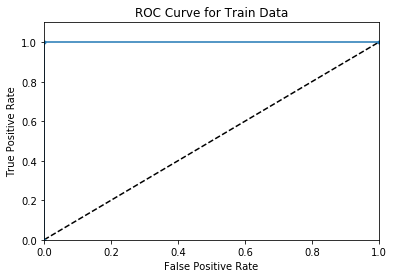

----------------------------------------------
AUC FOR TRAIN DATA: 1.0
----------------------------------------------
----------------------------------------------
ROC FOR TEST DATA:
----------------------------------------------


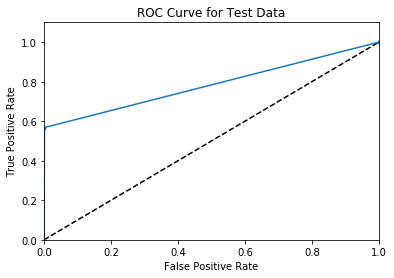

----------------------------------------------
AUC FOR TEST DATA: 0.783
----------------------------------------------


In [42]:
BRFTrainFPR, BRFTrainTPR, BRFTrainThreshold = roc_curve(actualTrainDataY, balancedRFTrainPredY)
BRFTrainAUC = round(roc_auc_score(actualTrainDataY, balancedRFTrainPredY), 3)

print('----------------------------------------------')
print("ROC FOR TRAIN DATA:")
print('----------------------------------------------')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.plot(BRFTrainFPR, BRFTrainTPR, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Train Data")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.show()
print('----------------------------------------------')
print("AUC FOR TRAIN DATA:", BRFTrainAUC)
print('----------------------------------------------')


BRFTestFPR, BRFTestTPR, BRFTestThreshold = roc_curve(actualTestDataY, balancedRFTestPredY)
BRFTestAUC = round(roc_auc_score(actualTestDataY, balancedRFTestPredY), 3)

print('----------------------------------------------')
print("ROC FOR TEST DATA:")
print('----------------------------------------------')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.plot(BRFTestFPR, BRFTestTPR, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Test Data")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.show()
print('----------------------------------------------')
print("AUC FOR TEST DATA:", BRFTestAUC)
print('----------------------------------------------')


In [43]:
tableData = []
row = []
row.append('Train Accuracy')
row.append(rfTrainAccuracy)
row.append(balancedRFTrainAccuracy)
tableData.append(row)
row = []
row.append('Test Accuracy')
row.append(rfTestAccuracy)
row.append(balancedRFTestAccuracy)
tableData.append(row)
row = []
row.append('OOB Error')
row.append(oobError)
row.append(balancedOOBError)
tableData.append(row)
row = []
row.append('Test Error')
row.append(rfTestError)
row.append(balancedRFTestError)
tableData.append(row)
row = []
row.append('Train AUC')
row.append(RFTrainAUC)
row.append(BRFTrainAUC)
tableData.append(row)
row = []
row.append('Test AUC')
row.append(RFTestAUC)
row.append(BRFTestAUC)
tableData.append(row)
tableHeaders = ['Measure', 'Random Forest with Class Imbalance', 'Random Forest without Class Imbalance']
printDatainTable(tableHeaders, tableData)

+================+====================================+=======================================+
|    Measure     | Random Forest with Class Imbalance | Random Forest without Class Imbalance |
+================+====================================+=======================================+
| Train Accuracy |                1.0                 |                  1.0                  |
+----------------+------------------------------------+---------------------------------------+
| Test Accuracy  |               0.992                |                 0.989                 |
+----------------+------------------------------------+---------------------------------------+
|   OOB Error    |               0.006                |                 0.007                 |
+----------------+------------------------------------+---------------------------------------+
|   Test Error   |               0.008                |                 0.011                 |
+----------------+----------------------

## Findings:
It is clear from the results that resampling has increased the accuracy of test data for Random Forest.

# Logistic Model Trees.

In [95]:
# Load the TRAIN DATA AND TEST DATA into LOADER for weka
loader = Loader(classname="weka.core.converters.ArffLoader")
data_train = loader.load_file("aps_train_data.arff")
data_train.class_is_first()

data_test = loader.load_file("aps_test_data.arff")
data_test.class_is_first()

In [96]:
# Build the LMT classifier
classifier = Classifier(classname="weka.classifiers.trees.LMT")
classifier.build_classifier(data_train)

In [97]:
#EVALUATE THE TRAIN DATA WITH CV=5
evaluation_train = Evaluation(data_train)
evaluation_train.crossvalidate_model(classifier, data_train, 5, Random(1))

----------------------------------------------
CONFUSION MATRIX for TRAIN DATA: 
+============+===============+===============+
|            | Predicted Pos | Predicted Neg |
+------------+---------------+---------------+
| Actual Pos |      653      |      347      |
+------------+---------------+---------------+
| Actual Neg |      171      |     58829     |
+------------+---------------+---------------+
----------------------------------------------
MEAN SQUARED ERROR for TRAIN DATA: 0.084
----------------------------------------------
AUC FOR TRAIN DATA: 0.959
----------------------------------------------
ROC Curve for TRAIN DATA


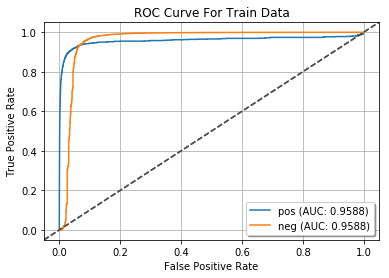

In [152]:
area=javabridge.static_call(
"weka/classifiers/evaluation/ThresholdCurve", "getROCArea", "(Lweka/core/Instances;)D", data_train.jobject)

print('----------------------------------------------')
print("CONFUSION MATRIX for TRAIN DATA: ")
confusion_matrix_train_data = evaluation_train.matrix()
confusionLines = confusion_matrix_train_data.split('\n')
LMTTrainTP = confusionLines[3].strip().split('  ')[0]
LMTTrainFN = confusionLines[3].strip().split('  ')[1].replace('|', '').strip()
LMTTrainFP = confusionLines[4].strip().split(' ')[0]
LMTTrainTN = confusionLines[4].strip().split(' ')[1].replace('|', '').strip()
printConfusionMatrix(LMTTrainTN, LMTTrainFP, LMTTrainFN, LMTTrainTP)

trainMSE = evaluation_train.root_mean_squared_error
trainMSE = round(trainMSE, 3)
print('----------------------------------------------')
print('MEAN SQUARED ERROR for TRAIN DATA:', trainMSE)
print('----------------------------------------------')

auc_score_train_data = evaluation_train.area_under_roc(1)
auc_score_train_data = round(auc_score_train_data, 3)
print("AUC FOR TRAIN DATA:", auc_score_train_data)
print('----------------------------------------------')
print("ROC Curve for TRAIN DATA")
pl2.plot_roc(evaluation_train, title="ROC Curve For Train Data", class_index=[0, 1], wait=False)

In [100]:
evaluation_test = Evaluation(data_test)
LMT_YPreds = evaluation_test.test_model(classifier, data_test)

LMT_YPreds_Rounded = []
for instance in LMT_YPreds:
    LMT_YPreds_Rounded.append(round(instance))

----------------------------------------------
CONFUSION MATRIX for TEST DATA:
+============+===============+===============+
|            | Predicted Pos | Predicted Neg |
+------------+---------------+---------------+
| Actual Pos |      267      |      108      |
+------------+---------------+---------------+
| Actual Neg |      47       |     15578     |
+------------+---------------+---------------+
----------------------------------------------
MEAN SQUARED ERROR for TEST DATA: 0.01
----------------------------------------------
AUC FOR TEST DATA: 0.854
----------------------------------------------
ROC FOR TEST DATA:


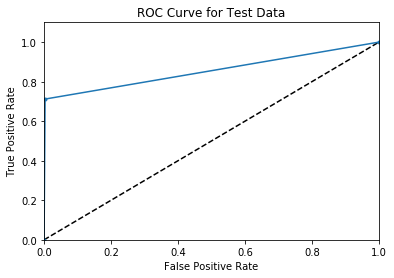

In [153]:
area=javabridge.static_call(
"weka/classifiers/evaluation/ThresholdCurve", "getROCArea", "(Lweka/core/Instances;)D", data_test.jobject)

print('----------------------------------------------')
print("CONFUSION MATRIX for TEST DATA:")
LMTTestConfusionMatrix = confusion_matrix(actualTestDataY, LMT_YPreds_Rounded)
LMTTestTN,LMTTestFP, LMTTestFN, LMTestTP = LMTTestConfusionMatrix.ravel()
printConfusionMatrix(LMTTestTN,LMTTestFP, LMTTestFN, LMTestTP)

testMSE = mean_squared_error(actualTestDataY, LMT_YPreds_Rounded)
testMSE = round(testMSE, 3)
print('----------------------------------------------')
print('MEAN SQUARED ERROR for TEST DATA:', testMSE)

print('----------------------------------------------')
auc_score_test_data = roc_auc_score(actualTestDataY, LMT_YPreds_Rounded)
auc_score_test_data = round(auc_score_test_data, 3)
print("AUC FOR TEST DATA:", auc_score_test_data)
LMTTestFPR, LMTTestTPR, LMTTestThreshold = roc_curve(actualTestDataY, LMT_YPreds_Rounded)

print('----------------------------------------------')
print("ROC FOR TEST DATA:")
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.plot(LMTTestFPR, LMTTestTPR, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Test Data")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.show()

# Logistic Model Trees after applying SMOTE.

In [132]:
actualTrainDataY_smothe = np.array(actualTrainDataY.copy())
print('----------------------------------------------')
print('Before SMOTE:')
print("Count of label 'POS': {}".format(sum(actualTrainDataY_smothe==1)))
print("Count of label 'NEG': {}".format(sum(actualTrainDataY_smothe==0)))
print('----------------------------------------------')

sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(apsTrainDataX, actualTrainDataY_smothe.ravel())

print('After SMOTE:')
print("Count of label 'POS': {}".format(sum(y_train_res==1)))
print("Count of label 'NEG': {}".format(sum(y_train_res==0)))
print('----------------------------------------------')

----------------------------------------------
Before SMOTE:
Count of label 'POS': 1000
Count of label 'NEG': 59000
----------------------------------------------
After SMOTE:
Count of label 'POS': 59000
Count of label 'NEG': 59000
----------------------------------------------


In [133]:
# Load the TRAIN DATA AFTER SMOTE into LOADER for weka
data_train_after_smote = loader.load_file("aps_train_data_after_smote.arff")
data_train_after_smote.class_is_first()

In [134]:
## Build the LMT classifier on TRAIN DATA after SMOTE
classifier_smote = Classifier(classname="weka.classifiers.trees.LMT")
classifier_smote.build_classifier(data_train_after_smote)

In [135]:
#EVALUATE THE TRAIN DATA WITH CV=5
evaluation_train_smote = Evaluation(data_train_after_smote)
evaluation_train_smote.crossvalidate_model(classifier_smote, data_train_after_smote, 5, Random(1))

----------------------------------------------
CONFUSION MATRIX for TRAIN DATA: 
+============+===============+===============+
|            | Predicted Pos | Predicted Neg |
+------------+---------------+---------------+
| Actual Pos |     57815     |     1185      |
+------------+---------------+---------------+
| Actual Neg |     1175      |     57825     |
+------------+---------------+---------------+
----------------------------------------------
MEAN SQUARED ERROR for TRAIN DATA: 0.13
----------------------------------------------
AUC FOR TRAIN DATA: 0.995
----------------------------------------------
ROC Curve for TRAIN DATA


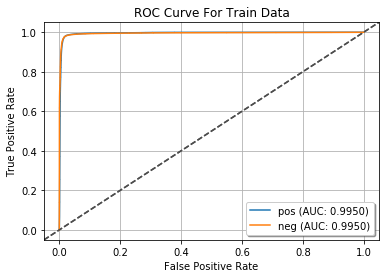

In [154]:
area=javabridge.static_call(
"weka/classifiers/evaluation/ThresholdCurve", "getROCArea", "(Lweka/core/Instances;)D", data_train.jobject)

print('----------------------------------------------')
print("CONFUSION MATRIX for TRAIN DATA: ")
confusion_matrix_smote_train_data = evaluation_train_smote.matrix()
confusionSMOTELines = confusion_matrix_smote_train_data.split('\n')
LMTSMOTETrainTP = confusionSMOTELines[3].strip().split('  ')[0]
LMTSMOTETrainFN = confusionSMOTELines[3].strip().split('  ')[1].replace('|', '').strip()
LMTSMOTETrainFP = confusionSMOTELines[4].strip().split(' ')[0]
LMTSMOTETrainTN = confusionSMOTELines[4].strip().split(' ')[1].replace('|', '').strip()
printConfusionMatrix(LMTSMOTETrainTN, LMTSMOTETrainFP, LMTSMOTETrainFN, LMTSMOTETrainTP)

TrainSMOTEMSE = evaluation_train_smote.root_mean_squared_error
TrainSMOTEMSE = round(TrainSMOTEMSE, 3)
print('----------------------------------------------')
print('MEAN SQUARED ERROR for TRAIN DATA:', TrainSMOTEMSE)
print('----------------------------------------------')

auc_score_SMOTE_train_data = evaluation_train_smote.area_under_roc(1)
auc_score_SMOTE_train_data = round(auc_score_SMOTE_train_data, 3)
print("AUC FOR TRAIN DATA:", auc_score_SMOTE_train_data)
print('----------------------------------------------')
print("ROC Curve for TRAIN DATA")
pl2.plot_roc(evaluation_train_smote, title="ROC Curve For Train Data", class_index=[0, 1], wait=False)

In [137]:
evaluation_test_smote = Evaluation(data_test)
LMT_YPredsSMOTE = evaluation_test_smote.test_model(classifier_smote, data_test)

LMT_YPreds_RoundedSMOTE = []
for instance in LMT_YPredsSMOTE:
    LMT_YPreds_RoundedSMOTE.append(round(instance))

----------------------------------------------
CONFUSION MATRIX for TEST DATA:
+============+===============+===============+
|            | Predicted Pos | Predicted Neg |
+------------+---------------+---------------+
| Actual Pos |      317      |      58       |
+------------+---------------+---------------+
| Actual Neg |      218      |     15407     |
+------------+---------------+---------------+
----------------------------------------------
MEAN SQUARED ERROR for TEST DATA: 0.017
----------------------------------------------
AUC FOR TEST DATA: 0.916
----------------------------------------------
ROC FOR TEST DATA:


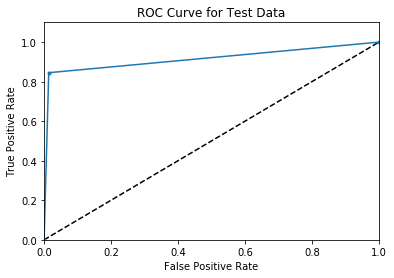

In [155]:
area=javabridge.static_call(
"weka/classifiers/evaluation/ThresholdCurve", "getROCArea", "(Lweka/core/Instances;)D", data_test.jobject)

print('----------------------------------------------')
print("CONFUSION MATRIX for TEST DATA:")
LMTSMOTETestConfusionMatrix = confusion_matrix(actualTestDataY, LMT_YPreds_RoundedSMOTE)
LMTSMOTETestTN,LMTSMOTETestFP, LMTSMOTETestFN, LMTSMOTETestTP = LMTSMOTETestConfusionMatrix.ravel()
printConfusionMatrix(LMTSMOTETestTN,LMTSMOTETestFP, LMTSMOTETestFN, LMTSMOTETestTP)

TestSMOTEMSE = mean_squared_error(actualTestDataY, LMT_YPreds_RoundedSMOTE)
TestSMOTEMSE = round(TestSMOTEMSE, 3)
print('----------------------------------------------')
print('MEAN SQUARED ERROR for TEST DATA:', TestSMOTEMSE)

print('----------------------------------------------')
auc_score_smote_test_data = roc_auc_score(actualTestDataY, LMT_YPreds_RoundedSMOTE)
auc_score_smote_test_data = round(auc_score_smote_test_data, 3)
print("AUC FOR TEST DATA:", auc_score_smote_test_data)
LMTSMOTETestFPR, LMTSMOTETestTPR, LMTSMOTETestThreshold = roc_curve(actualTestDataY, LMT_YPreds_RoundedSMOTE)

print('----------------------------------------------')
print("ROC FOR TEST DATA:")
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.plot(LMTSMOTETestFPR, LMTSMOTETestTPR, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Test Data")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.show()

In [156]:
jvm.stop()